In [2]:
import zipfile
import pandas as pd

# Define the path to the zip file and the CSV file inside it
zip_path = '/content/drive/MyDrive/data_comp.zip'
csv_filename = 'consumer_complaints.csv'

# Open the zip file and load the CSV file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open(csv_filename) as file:
        complaints_data = pd.read_csv(file)

# Displaying the first few raws of the dataframe
complaints_data.head()

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk import ngrams
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import zipfile


In [4]:
# Get a summary of the dataset, including data types and non-null counts
complaints_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162421 entries, 0 to 162420
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  162421 non-null  int64 
 1   product     162421 non-null  object
 2   narrative   162411 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


The first column does not seem to have a role in the model therefore I have dropped it

In [5]:
complaints_data.drop(['Unnamed: 0'], axis=1, inplace=True)
print('Current size of dataframe is {}'.format(complaints_data.shape))
print('Number of duplicated rows: ', complaints_data.duplicated().sum())
print('Number of empty cells in each column: ')
print(complaints_data.isna().sum())

Current size of dataframe is (162421, 2)
Number of duplicated rows:  37742
Number of empty cells in each column: 
product       0
narrative    10
dtype: int64


In [6]:
#dropping the null values
complaints_data = complaints_data.dropna(subset=['narrative'])

In [7]:
# Removing duplicate entries based on 'product' and 'narrative' columns
complaints_data = complaints_data.drop_duplicates(subset=['product', 'narrative'])

# Checking the new shape of the dataset
complaints_data.shape

(124676, 2)

<ipython-input-8-439c4dada1a4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complaints_data['text_length'] = complaints_data['narrative'].apply(len)


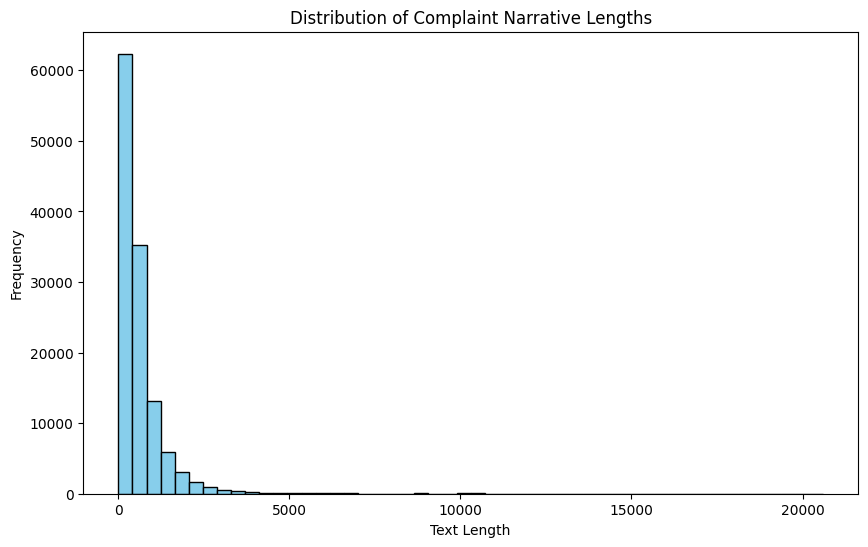

,text_length
count,124676.000000
mean,633.359484
std,832.511639
min,3.000000
25%,219.000000
50%,414.000000
75%,752.000000
max,20596.000000


In [8]:
import matplotlib.pyplot as plt

# Calculating the length of each complaint narrative
complaints_data['text_length'] = complaints_data['narrative'].apply(len)

# Summary statistics for text length
text_length_summary = complaints_data['text_length'].describe()

# Plotting the distribution of text length
plt.figure(figsize=(10, 6))
plt.hist(complaints_data['text_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Complaint Narrative Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

text_length_summary

In [9]:

nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stopwords and lemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# define the preprocessing function
def preprocess_text(text):
    # Check if text is a valid string
    if isinstance(text, str):
        # Lowercase conversion
        text = text.lower()
        # Remove special characters and numbers
        text = re.sub(r'\W|\d', ' ', text)
        # Tokenize and remove stopwords
        words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
        # Join words back to string
        return ' '.join(words)
    else:
        # Return an empty string if the text is NaN
        return ''

# Apply preprocessing

complaints_data['processed_text'] = complaints_data['narrative'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [10]:
# Displaying a sample of the cleaned narratives
complaints_data[['narrative', 'processed_text']].head()

,narrative,processed_text
0,purchase order day shipping amount receive pro...,purchase order day shipping amount receive pro...
1,forwarded message date tue subject please inve...,forwarded message date tue subject please inve...
2,forwarded message cc sent friday pdt subject f...,forwarded message cc sent friday pdt subject f...
3,payment history missing credit report speciali...,payment history missing credit report speciali...
4,payment history missing credit report made mis...,payment history missing credit report made mis...


EDA

In [11]:
# Word Frequency
word_freq = Counter(" ".join(complaints_data['processed_text']).split())
print(word_freq.most_common(10))

# Bigrams and Trigrams
bigrams = Counter(ngrams(" ".join(complaints_data['processed_text']).split(), 2))
trigrams = Counter(ngrams(" ".join(complaints_data['processed_text']).split(), 3))
print(bigrams.most_common(10))
print(trigrams.most_common(10))

[('account', 252929), ('credit', 239624), ('report', 124293), ('payment', 118364), ('information', 104300), ('time', 73355), ('would', 72341), ('loan', 70670), ('company', 67883), ('card', 66771)]
[(('credit', 'report'), 69666), (('credit', 'card'), 26508), (('credit', 'bureau'), 21540), (('credit', 'reporting'), 19092), (('identity', 'theft'), 16530), (('credit', 'score'), 13375), (('account', 'number'), 12264), (('late', 'payment'), 12030), (('customer', 'service'), 11633), (('reporting', 'agency'), 11517)]
[(('fair', 'credit', 'reporting'), 8697), (('credit', 'reporting', 'act'), 8650), (('credit', 'reporting', 'agency'), 6159), (('victim', 'identity', 'theft'), 4849), (('consumer', 'reporting', 'agency'), 4599), (('information', 'credit', 'report'), 4487), (('account', 'credit', 'report'), 3983), (('removed', 'credit', 'report'), 3673), (('social', 'security', 'number'), 3146), (('opened', 'balance', 'account'), 3135)]


In [12]:
# Checking the distribution of the 'product' categories
product_distribution = complaints_data['product'].value_counts()

product_distribution

,count
product,
credit_reporting,56303
debt_collection,21117
mortgages_and_loans,18759
credit_card,15024
retail_banking,13473


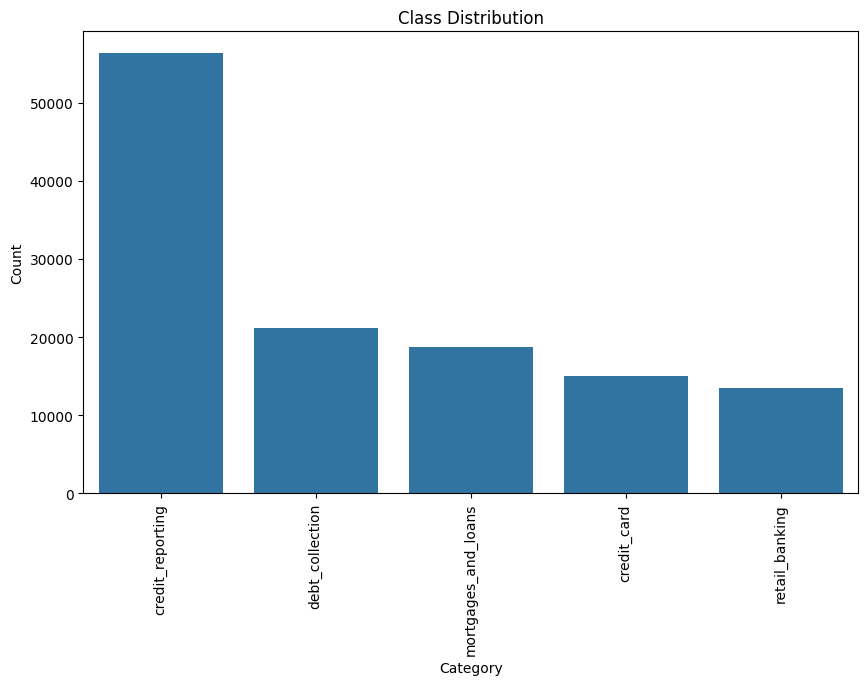

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def class_distribution_plot(title: str, x):
    # Calculate counts and sort by descending order
    value_counts = x.value_counts().sort_values(ascending=False)

    # Plot the sorted values
    plt.figure(figsize=(10, 6))
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.title(title)
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=90)  # Rotate x labels if needed
    plt.show()


class_distribution_plot('Class Distribution', complaints_data['product'])


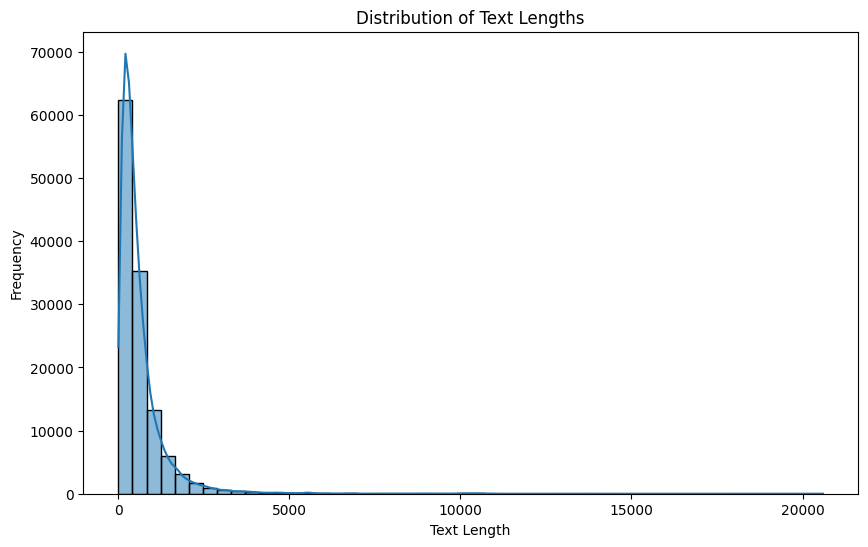

In [14]:
# Calculate the length of each complaint
complaints_data['text_length'] = complaints_data['narrative'].astype(str).apply(len)

# Plot the distribution of text length
plt.figure(figsize=(10, 6))
sns.histplot(complaints_data['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


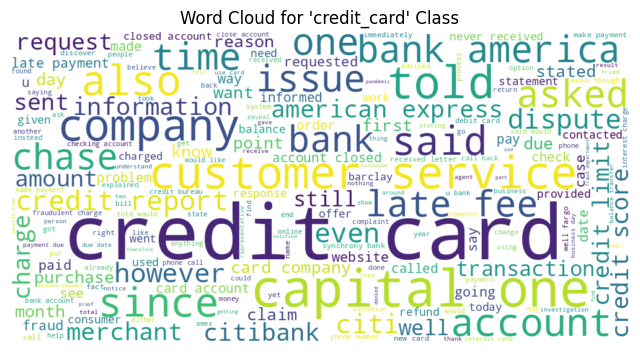

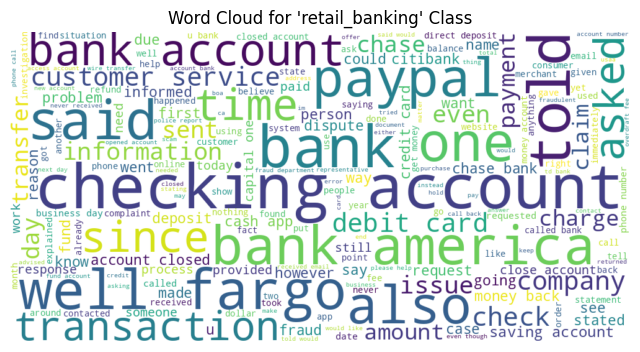

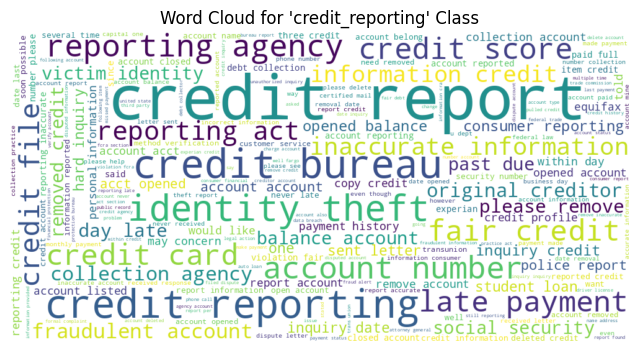

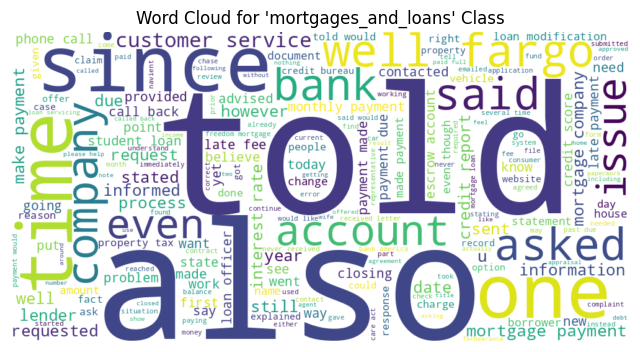

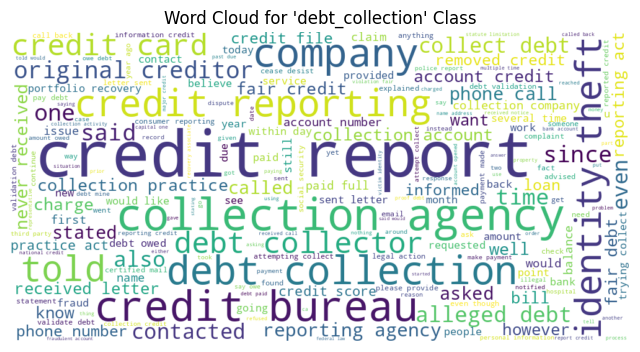

In [15]:
def wordcloud_for_class(title:str, text:str):
    wordcloud = WordCloud(width=1000, height=500, background_color='white', stopwords=set(stopwords.words('english'))).generate(text)
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show

for product_class in complaints_data["product"].unique():
    class_text = ' '.join(complaints_data[complaints_data['product'] == product_class]['processed_text'])
    wordcloud_for_class(f"Word Cloud for '{product_class}' Class", class_text)

In [16]:
# Calculate text length if not already present
if 'text_length' not in complaints_data.columns:
    complaints_data['text_length'] = complaints_data['processed_text'].apply(len)

# Calculate word count if not already present
if 'number_of_words' not in complaints_data.columns:
    complaints_data['number_of_words'] = complaints_data['processed_text'].apply(lambda x: len(x.split()))

# Adding text length column (character count for each narrative)
complaints_data['text_length'] = complaints_data['processed_text'].apply(len)

# Adding word count column (number of words in each narrative)
complaints_data['number_of_words'] = complaints_data['processed_text'].apply(lambda x: len(x.split()))

# Display the relevant columns in the DataFrame
cleaned_complaints_data = complaints_data[['product', 'processed_text', 'text_length', 'number_of_words']]

# View the first few rows
cleaned_complaints_data.head()

,product,processed_text,text_length,number_of_words
0,credit_card,purchase order day shipping amount receive pro...,1705,230
1,credit_card,forwarded message date tue subject please inve...,904,132
2,retail_banking,forwarded message cc sent friday pdt subject f...,1230,173
3,credit_reporting,payment history missing credit report speciali...,903,131
4,credit_reporting,payment history missing credit report made mis...,851,123


In [17]:
from sklearn.preprocessing import LabelEncoder

# Ensure cleaned_df is a copy of the original DataFrame
cleaned_complaints_data = cleaned_complaints_data.copy()

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Encode the 'product' column and assign it to the new 'target' column
cleaned_complaints_data['target'] = label_encoder.fit_transform(cleaned_complaints_data['product'])

# Display the first few rows to verify the target encoding
cleaned_complaints_data.head()

,product,processed_text,text_length,number_of_words,target
0,credit_card,purchase order day shipping amount receive pro...,1705,230,0
1,credit_card,forwarded message date tue subject please inve...,904,132,0
2,retail_banking,forwarded message cc sent friday pdt subject f...,1230,173,4
3,credit_reporting,payment history missing credit report speciali...,903,131,1
4,credit_reporting,payment history missing credit report made mis...,851,123,1


In [18]:
from sklearn.model_selection import train_test_split

# Separate the features (X) and target (y)
X = cleaned_complaints_data['processed_text']
y = cleaned_complaints_data['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting splits
print("Training set shapes (X_train, y_train):", X_train.shape, y_train.shape)
print("Testing set shapes (X_test, y_test):", X_test.shape, y_test.shape)


Training set shapes (X_train, y_train): (99740,) (99740,)
Testing set shapes (X_test, y_test): (24936,) (24936,)


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)



In [20]:
from sklearn.preprocessing import MinMaxScaler
# Apply MinMax Scaling
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both train and test data
X_train_scaled = scaler.fit_transform(X_train_tfidf.toarray())
X_test_scaled = scaler.transform(X_test_tfidf.toarray())

# Print the shapes of the transformed features to verify
print("Scaled Training set shape:", X_train_scaled.shape)
print("Scaled Testing set shape:", X_test_scaled.shape)

Scaled Training set shape: (99740, 5000)
Scaled Testing set shape: (24936, 5000)


 Model Selection & Training

Model 1: Logistic Regression Baseline model

Accuracy (Baseline Logistic Regression): 0.8445219762592237
Classification Report (Baseline Logistic Regression):
               precision    recall  f1-score   support

           0       0.79      0.77      0.78      3004
           1       0.88      0.89      0.89     11338
           2       0.80      0.75      0.77      4157
           3       0.84      0.84      0.84      3741
           4       0.85      0.87      0.86      2696

    accuracy                           0.84     24936
   macro avg       0.83      0.82      0.83     24936
weighted avg       0.84      0.84      0.84     24936



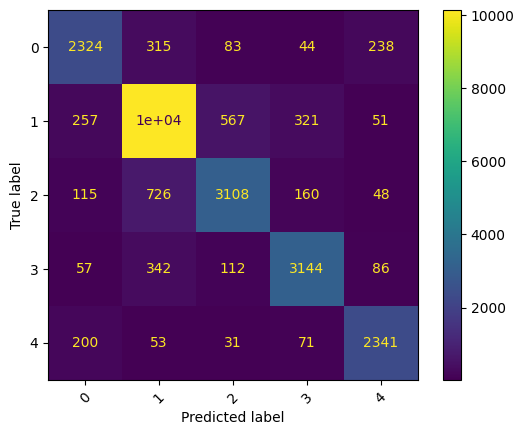

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
# Initialize and train the Logistic Regression model
baseline_lr_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_lr_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_base_lr = baseline_lr_model.predict(X_test_scaled)

# Calculate accuracy and classification report
accuracy_base_lr = accuracy_score(y_test, y_pred_base_lr)
report_base_lr = classification_report(y_test, y_pred_base_lr)

# Display the evaluation scores
print(f"Accuracy (Baseline Logistic Regression): {accuracy_base_lr}")
print("Classification Report (Baseline Logistic Regression):\n", report_base_lr)

# Display the confusion matrix
ConfusionMatrixDisplay.from_estimator(baseline_lr_model, X_test_scaled, y_test, xticks_rotation=45)
plt.show()


Model 2: Naive Bayes Baseline model

Accuracy (Baseline MultinomialNB): 0.8047000320821303
Classification Report (Baseline MultinomialNB):
               precision    recall  f1-score   support

           0       0.70      0.75      0.73      3004
           1       0.86      0.84      0.85     11338
           2       0.78      0.65      0.71      4157
           3       0.76      0.87      0.81      3741
           4       0.81      0.85      0.83      2696

    accuracy                           0.80     24936
   macro avg       0.78      0.79      0.79     24936
weighted avg       0.81      0.80      0.80     24936



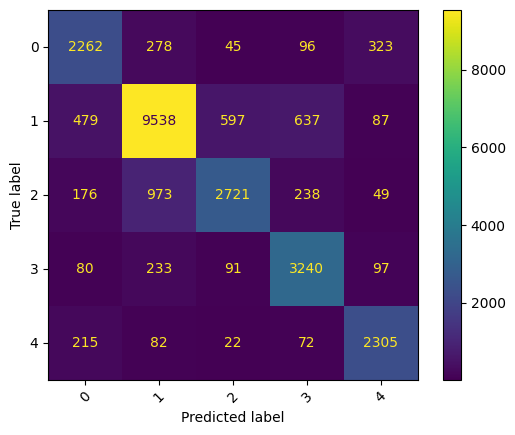

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the Multinomial Naive Bayes model
baseline_nb_model = MultinomialNB()
baseline_nb_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_base_nb = baseline_nb_model.predict(X_test_scaled)

# Calculate accuracy and classification report
accuracy_base_nb = accuracy_score(y_test, y_pred_base_nb)
report_base_nb = classification_report(y_test, y_pred_base_nb)

# Display the evaluation scores
print(f"Accuracy (Baseline MultinomialNB): {accuracy_base_nb}")
print("Classification Report (Baseline MultinomialNB):\n", report_base_nb)

# Display the confusion matrix
ConfusionMatrixDisplay.from_estimator(baseline_nb_model, X_test_scaled, y_test, xticks_rotation=45)
plt.show()


Model 3: Random Forest Classifier Baseline model

Accuracy (Baseline Random Forest): 0.849534809111325
Classification Report (Baseline Random Forest):
               precision    recall  f1-score   support

           0       0.82      0.73      0.77      3004
           1       0.85      0.95      0.90     11338
           2       0.85      0.71      0.78      4157
           3       0.87      0.81      0.84      3741
           4       0.85      0.83      0.84      2696

    accuracy                           0.85     24936
   macro avg       0.85      0.81      0.83     24936
weighted avg       0.85      0.85      0.85     24936



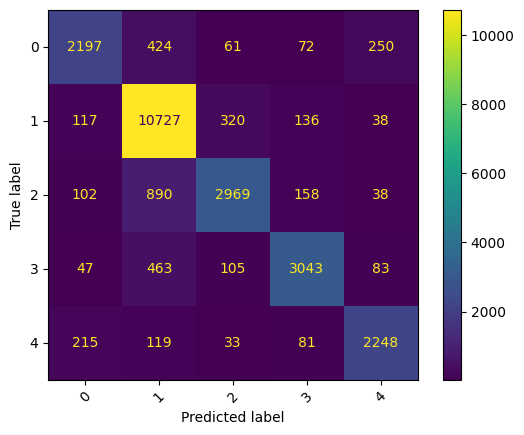

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the Random Forest model
baseline_rf_model = RandomForestClassifier(random_state=42)
baseline_rf_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_base_rf = baseline_rf_model.predict(X_test_scaled)

# Calculate accuracy and classification report
accuracy_base_rf = accuracy_score(y_test, y_pred_base_rf)
report_base_rf = classification_report(y_test, y_pred_base_rf)

# Display the evaluation scores
print(f"Accuracy (Baseline Random Forest): {accuracy_base_rf}")
print("Classification Report (Baseline Random Forest):\n", report_base_rf)

# Display the confusion matrix
ConfusionMatrixDisplay.from_estimator(baseline_rf_model, X_test_scaled, y_test, xticks_rotation=45)
plt.show()

 Model 4: Linear SVC Baseline Model

Accuracy (Baseline SVM): 0.8395091434071222
Classification Report (Baseline SVM):
               precision    recall  f1-score   support

           0       0.78      0.76      0.77      3004
           1       0.88      0.89      0.88     11338
           2       0.79      0.75      0.77      4157
           3       0.83      0.83      0.83      3741
           4       0.84      0.86      0.85      2696

    accuracy                           0.84     24936
   macro avg       0.82      0.82      0.82     24936
weighted avg       0.84      0.84      0.84     24936



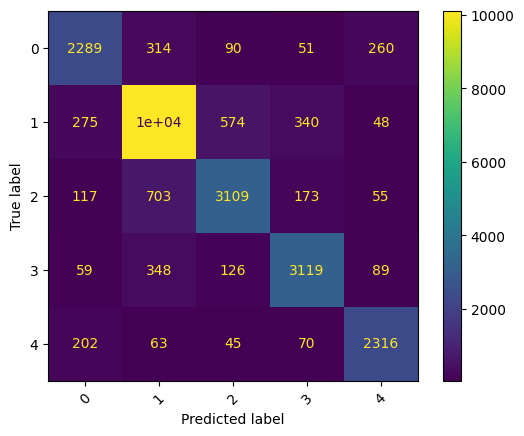

In [24]:
from sklearn.svm import LinearSVC
#  Initialize and train the SVM model
baseline_svm_model = LinearSVC(max_iter=1000, random_state=42)
baseline_svm_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_base_svm = baseline_svm_model.predict(X_test_scaled)

#  Calculate accuracy and classification report
accuracy_base_svm = accuracy_score(y_test, y_pred_base_svm)
report_base_svm = classification_report(y_test, y_pred_base_svm)

#  Display the evaluation scores
print(f"Accuracy (Baseline SVM): {accuracy_base_svm}")
print("Classification Report (Baseline SVM):\n", report_base_svm)

# Display the confusion matrix
ConfusionMatrixDisplay.from_estimator(baseline_svm_model, X_test_scaled, y_test, xticks_rotation=45)
plt.show()


In [25]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Extra Trees Classifier
baseline_et_model = ExtraTreesClassifier(n_estimators=100, random_state=42)

# Train the model
baseline_et_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_base_et = baseline_et_model.predict(X_test_scaled)

# Evaluate the model
accuracy_base_et = accuracy_score(y_test, y_pred_base_et)
report_base_et = classification_report(y_test, y_pred_base_et)

print(f"Accuracy (Baseline Extra Trees): {accuracy_base_et}")
print("Classification Report (Baseline Extra Trees):\n", report_base_et)

Accuracy (Baseline Extra Trees): 0.8588386268848252
Classification Report (Baseline Extra Trees):
               precision    recall  f1-score   support

           0       0.83      0.75      0.79      3004
           1       0.86      0.94      0.90     11338
           2       0.86      0.73      0.79      4157
           3       0.87      0.84      0.85      3741
           4       0.85      0.85      0.85      2696

    accuracy                           0.86     24936
   macro avg       0.85      0.82      0.84     24936
weighted avg       0.86      0.86      0.86     24936



Model 5: Gradient Boosting Classifier Baseline Model

In [26]:
!pip install xgboost --upgrade

In [27]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message='Parameters: { "use_label_encoder" } are not used.')

In [28]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Initialize and train the XGBoost model
baseline_xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
baseline_xgb_model.fit(X_train_scaled, y_train)

# Step 2: Make predictions on the test set
y_pred_base_xgb = baseline_xgb_model.predict(X_test_scaled)

# Step 3: Calculate accuracy and classification report
accuracy_base_xgb = accuracy_score(y_test, y_pred_base_xgb)
report_base_xgb = classification_report(y_test, y_pred_base_xgb)

# Step 4: Display the evaluation scores
print(f"Accuracy (Baseline XGBoost): {accuracy_base_xgb}")
print("Classification Report (Baseline XGBoost):\n", report_base_xgb)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:39:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy (Baseline XGBoost): 0.8486525505293552
Classification Report (Baseline XGBoost):
               precision    recall  f1-score   support

           0       0.81      0.78      0.79      3004
           1       0.87      0.90      0.89     11338
           2       0.80      0.75      0.77      4157
           3       0.86      0.84      0.85      3741
           4       0.86      0.85      0.85      2696

    accuracy                           0.85     24936
   macro avg       0.84      0.83      0.83     24936
weighted avg       0.85      0.85      0.85     24936



In [29]:
# Define the prediction function
def predict_complaint_category(narrative, model, vectorizer, scaler, label_encoder):
    # Preprocess the narrative
    cleaned_narrative = preprocess_text(narrative)

    # Transform the narrative using TF-IDF vectorizer
    narrative_tfidf = vectorizer.transform([cleaned_narrative])

    # Scale the TF-IDF features
    narrative_scaled = scaler.transform(narrative_tfidf.toarray())

    # Predict the category
    prediction = model.predict(narrative_scaled)

    # Decode the numeric label to the original category
    predicted_category = label_encoder.inverse_transform(prediction)

    return predicted_category[0]

# Dummy data for testing
dummy_data = [
    "I am very unhappy with the service I received from my credit card company.",
    "The bank has charged me extra fees without any notice.",
    "My mortgage application was denied without a valid reason.",
    "I have been receiving spam calls from a loan company.",
    "The insurance company is not processing my claim."
]

# Test the predictive system with dummy data
for narrative in dummy_data:
    predicted_category = predict_complaint_category(narrative, baseline_et_model, tfidf_vectorizer, scaler, label_encoder)
    print(f"Narrative: {narrative}\nPredicted Category: {predicted_category}\n")

Narrative: I am very unhappy with the service I received from my credit card company.
Predicted Category: credit_card

Narrative: The bank has charged me extra fees without any notice.
Predicted Category: retail_banking

Narrative: My mortgage application was denied without a valid reason.
Predicted Category: mortgages_and_loans

Narrative: I have been receiving spam calls from a loan company.
Predicted Category: mortgages_and_loans

Narrative: The insurance company is not processing my claim.
Predicted Category: debt_collection

